In [1]:
import os
import subprocess

def git_repo_root():
    # Run the 'git rev-parse --show-toplevel' command to get the root directory of the Git repository
    try:
        root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], universal_newlines=True).strip()
        return root
    except subprocess.CalledProcessError:
        # Handle the case where the current directory is not inside a Git repository
        return None

# Get the root directory of the Git repository
git_root = git_repo_root()

if git_root:
    # Change the working directory to the root of the Git repository
    os.chdir(git_root)
    print(f"Changed working directory to: {git_root}")
else:
    print("Not inside a Git repository.")

Changed working directory to: C:/Users/tomas/Documents/GitHub/2dDiffusion


In [2]:
%load_ext autoreload
%autoreload 2

from diffusion import VPSDE
from data import generate_mixture_gaussians

epochs = 5000
# Make sure our diffusion process actually diffuses the data
data = generate_mixture_gaussians()
num_steps = 250

In [3]:
from training import loss_function
import torch
from diffusion import match_dim
from data import log_likelihood_mixture_gaussians_batch
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
from prodigyopt import Prodigy

def train_score_network(dataloader, score_net, sde, epochs=epochs, bridge=False, optimizer_str='adam', learning_rate=1e-4):
    """
    Trains the score network

    """
    optimizer = None
    if optimizer_str == 'adam':
        optimizer = torch.optim.Adam(score_net.parameters(), lr=learning_rate)
    else:
        optimizer = Prodigy(score_net.parameters())
    avg = 0
    epoch_ll = []
    ll_mean = []
    ll_std = []
    for epoch in tqdm(range(epochs)):
        for x_batch, in dataloader:
            optimizer.zero_grad()
            loss = loss_function(score_net, x_batch, sde, bridge=bridge)
            loss.backward()
            # nn.utils.clip_grad_norm_(score_net.parameters(), 1.0)
            optimizer.step()
            avg += loss
        
        if epoch % 10 == 0:
            samples = sde.backward_diffusion(score_net, data_shape=(1000, 2)).detach()
            lls = log_likelihood_mixture_gaussians_batch(samples).numpy()
            ll_mean.append(lls.mean())
            ll_std.append(lls.std())
            epoch_ll.append(epoch)


        if (((epoch + 1) % 500 == 0 and epoch != 0) or epoch == epochs-1):
            tqdm.write(f'Epoch: {epoch} and Loss: {avg/(8*1000)}')
            avg = 0
            # samples = sde.backward_diffusion(score_net, data_shape=(1000, 2))
            # data = x_batch.detach().numpy()
            # samples_np = samples.detach().numpy()
            # lls = log_likelihood_mixture_gaussians_batch(samples)
            # tqdm.write(f'Log Likelihood mean: {lls.mean()} and std: {lls.std()}')
            # plt.scatter(data[:, 0], data[:, 1], label='Original Data')
            # plt.scatter(samples_np[:, 0], samples_np[:,1], label='Generated Samples')
            # plt.legend()
            # plt.show()
    
    # plot log-likelihood mean across epochs with std shaded on top
    return ll_mean, ll_std, epoch_ll
    


In [4]:
from torch.utils.data import DataLoader, TensorDataset
from model import MLP


data = generate_mixture_gaussians(num_samples=4000)
dataloader = DataLoader(TensorDataset(data), batch_size=500, shuffle=True)

sde = VPSDE(num_steps, 0.1, 20, logarithmic_scheduling=False)
score_net = MLP()
ll_mean_alin, ll_std_alin, epoch_ll_alin = train_score_network(dataloader, score_net, sde, optimizer_str='adam', learning_rate=1e-4)


sde = VPSDE(num_steps, 0.1, 20, logarithmic_scheduling=True)
score_net = MLP()
ll_mean_alog, ll_std_alog, epoch_ll_alog = train_score_network(dataloader, score_net, sde, optimizer_str='adam', learning_rate=1e-4)


sde = VPSDE(num_steps, 0.1, 20, logarithmic_scheduling=False)
score_net = MLP()
ll_mean_plin, ll_std_plin, epoch_ll_plin = train_score_network(dataloader, score_net, sde, optimizer_str='prodigy')


sde = VPSDE(num_steps, 0.1, 20, logarithmic_scheduling=True)
score_net = MLP()
ll_mean_plog, ll_std_plog, epoch_ll_plog  = train_score_network(dataloader, score_net, sde, optimizer_str='prodigy')

# save the results
import pickle
results = {
    'll_mean_alin': ll_mean_alin,
    'll_std_alin': ll_std_alin,
    'epoch_ll_alin': epoch_ll_alin,
    'll_mean_alog': ll_mean_alog,
    'll_std_alog': ll_std_alog,
    'epoch_ll_alog': epoch_ll_alog,
    'll_mean_plin': ll_mean_plin,
    'll_std_plin': ll_std_plin,
    'epoch_ll_plin': epoch_ll_plin,
    'll_mean_plog': ll_mean_plog,
    'll_std_plog': ll_std_plog,
    'epoch_ll_plog': epoch_ll_plog
}
pickle.dump(results, open('llvsepochs.pkl', 'wb'))


  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
 10%|▉         | 499/5000 [01:01<06:18, 11.90it/s]

Epoch: 499 and Loss: 0.1012878566980362


 20%|█▉        | 999/5000 [02:01<05:30, 12.11it/s]

Epoch: 999 and Loss: 0.09466676414012909


 30%|██▉       | 1499/5000 [03:02<06:12,  9.39it/s]

Epoch: 1499 and Loss: 0.09449435770511627


 40%|███▉      | 1999/5000 [04:03<04:03, 12.30it/s]

Epoch: 1999 and Loss: 0.09291846305131912


 50%|████▉     | 2499/5000 [05:03<03:24, 12.23it/s]

Epoch: 2499 and Loss: 0.09331826120615005


 60%|█████▉    | 2999/5000 [06:04<02:42, 12.30it/s]

Epoch: 2999 and Loss: 0.09332603216171265


 70%|██████▉   | 3499/5000 [07:04<02:01, 12.32it/s]

Epoch: 3499 and Loss: 0.0930807814002037


 80%|███████▉  | 3999/5000 [08:05<01:22, 12.18it/s]

Epoch: 3999 and Loss: 0.09347859025001526


 90%|████████▉ | 4499/5000 [09:06<00:47, 10.61it/s]

Epoch: 4499 and Loss: 0.09328360110521317


100%|██████████| 5000/5000 [10:07<00:00,  8.24it/s]


Epoch: 4999 and Loss: 0.09365668147802353


 10%|▉         | 499/5000 [01:01<06:29, 11.54it/s]

Epoch: 499 and Loss: 0.8388113975524902


 20%|█▉        | 999/5000 [02:02<05:36, 11.89it/s]

Epoch: 999 and Loss: 0.8132212162017822


 30%|██▉       | 1499/5000 [03:03<04:53, 11.92it/s]

Epoch: 1499 and Loss: 0.810920238494873


 40%|███▉      | 1999/5000 [04:04<04:10, 11.96it/s]

Epoch: 1999 and Loss: 0.8099915385246277


 50%|████▉     | 2499/5000 [05:05<03:25, 12.17it/s]

Epoch: 2499 and Loss: 0.8065499067306519


 60%|█████▉    | 2999/5000 [06:06<02:45, 12.11it/s]

Epoch: 2999 and Loss: 0.8064859509468079


 70%|██████▉   | 3499/5000 [07:07<02:04, 12.10it/s]

Epoch: 3499 and Loss: 0.803593099117279


 80%|███████▉  | 3999/5000 [08:09<01:22, 12.10it/s]

Epoch: 3999 and Loss: 0.8057302832603455


 90%|████████▉ | 4499/5000 [09:10<00:41, 12.18it/s]

Epoch: 4499 and Loss: 0.804582953453064


100%|██████████| 5000/5000 [10:11<00:00,  8.18it/s]


Epoch: 4999 and Loss: 0.8047876358032227


 10%|▉         | 499/5000 [01:02<06:46, 11.07it/s]

Epoch: 499 and Loss: 0.09622342139482498


 20%|█▉        | 999/5000 [02:04<05:54, 11.28it/s]

Epoch: 999 and Loss: 0.09425225853919983


 30%|██▉       | 1499/5000 [03:08<05:14, 11.13it/s]

Epoch: 1499 and Loss: 0.09368406236171722


 40%|███▉      | 1999/5000 [04:12<04:30, 11.10it/s]

Epoch: 1999 and Loss: 0.09441777318716049


 50%|████▉     | 2499/5000 [05:17<03:42, 11.23it/s]

Epoch: 2499 and Loss: 0.09361870586872101


 60%|█████▉    | 2999/5000 [06:22<02:59, 11.16it/s]

Epoch: 2999 and Loss: 0.09403946250677109


 70%|██████▉   | 3499/5000 [07:29<02:23, 10.49it/s]

Epoch: 3499 and Loss: 0.09433005005121231


 80%|███████▉  | 3999/5000 [08:35<01:31, 10.98it/s]

Epoch: 3999 and Loss: 0.09322907030582428


 90%|████████▉ | 4499/5000 [09:41<00:45, 10.91it/s]

Epoch: 4499 and Loss: 0.09316025674343109


100%|██████████| 5000/5000 [10:47<00:00,  7.72it/s]


Epoch: 4999 and Loss: 0.09340611845254898


 10%|▉         | 499/5000 [01:02<06:23, 11.73it/s]

Epoch: 499 and Loss: 0.817384660243988


 20%|█▉        | 999/5000 [02:05<05:43, 11.63it/s]

Epoch: 999 and Loss: 0.8080573678016663


 30%|██▉       | 1499/5000 [03:07<05:01, 11.62it/s]

Epoch: 1499 and Loss: 0.8054308891296387


 40%|███▉      | 1999/5000 [04:11<04:20, 11.54it/s]

Epoch: 1999 and Loss: 0.8029020428657532


 50%|████▉     | 2499/5000 [05:14<03:39, 11.40it/s]

Epoch: 2499 and Loss: 0.7998561859130859


 60%|█████▉    | 2999/5000 [06:18<02:55, 11.43it/s]

Epoch: 2999 and Loss: 0.8002524971961975


 70%|██████▉   | 3499/5000 [07:22<02:27, 10.16it/s]

Epoch: 3499 and Loss: 0.7984849810600281


 80%|███████▉  | 3999/5000 [08:28<01:31, 10.90it/s]

Epoch: 3999 and Loss: 0.7984872460365295


 90%|████████▉ | 4499/5000 [09:32<00:45, 11.03it/s]

Epoch: 4499 and Loss: 0.7979356050491333


100%|██████████| 5000/5000 [10:37<00:00,  7.84it/s]

Epoch: 4999 and Loss: 0.7950105667114258


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


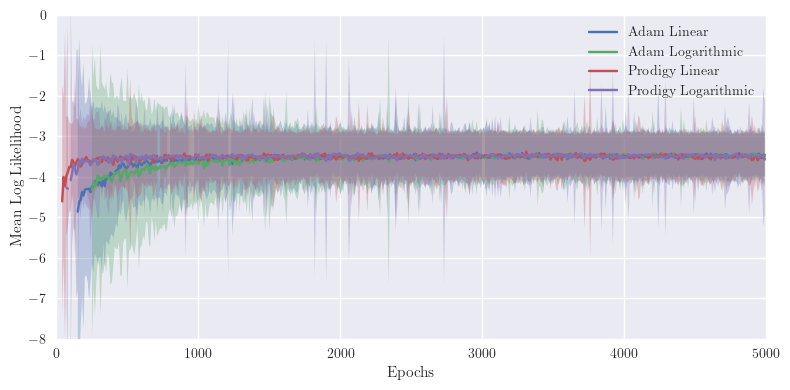

In [14]:
# Load results
import pickle
results = pickle.load(open('llvsepochs.pkl', 'rb'))
ll_mean_alin = results['ll_mean_alin']
ll_std_alin = results['ll_std_alin']
epoch_ll_alin = results['epoch_ll_alin']
ll_mean_alog = results['ll_mean_alog']
ll_std_alog = results['ll_std_alog']
epoch_ll_alog = results['epoch_ll_alog']
ll_mean_plin = results['ll_mean_plin']
ll_std_plin = results['ll_std_plin']
epoch_ll_plin = results['epoch_ll_plin']
ll_mean_plog = results['ll_mean_plog']
ll_std_plog = results['ll_std_plog']
epoch_ll_plog = results['epoch_ll_plog']

from matplotlib import pyplot as plt
import numpy as np
# Using seaborn's style
print(plt.style.available)
plt.style.use('seaborn-v0_8')
# width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
}

plt.rcParams.update(tex_fonts)

def plot_ll_vs_epochs(ll_mean, ll_std, epoch_ll, label):
    plt.plot(epoch_ll, ll_mean, label=label)
    plt.fill_between(epoch_ll, np.array(ll_mean) - np.array(ll_std), np.array(ll_mean) + np.array(ll_std), alpha=0.3)

plt.figure(figsize=(8, 4))
plot_ll_vs_epochs(ll_mean_alin, ll_std_alin, epoch_ll_alin, 'Adam Linear')
plot_ll_vs_epochs(ll_mean_alog, ll_std_alog, epoch_ll_alog, 'Adam Logarithmic')
plot_ll_vs_epochs(ll_mean_plin, ll_std_plin, epoch_ll_plin, 'Prodigy Linear')
plot_ll_vs_epochs(ll_mean_plog, ll_std_plog, epoch_ll_plog, 'Prodigy Logarithmic')


plt.xlim(0, 5000)
plt.ylim(-8, 0)
plt.ylabel('Mean Log Likelihood')
plt.xlabel('Epochs')
plt.legend()
plt.tight_layout()
plt.savefig('ll_vs_epochs.pdf')
plt.show()